# Project Mercedes Benz:


STEPS
1. Read the train and test data.
2. Predict the time taken for the Mercedes Benz to pass testing - time is continuous variable, so this is regression problem.
3. If for any column(s), the variance is equal to zero, then you need to remove those variable(s). - 
    #if the column has same values throughout that is uniquevalues is 1, drop it.
4. Check for null and unique values for test and train sets
5. Apply label encoder for categorical columns.
6. Perform dimensionality reduction.
7. Predict your test_df values using XGBoost.


In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Read the train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(4209, 378)

In [4]:
test.shape

(4209, 377)

In [5]:
train.columns

Index(['ID', 'y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8',
       ...
       'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384',
       'X385'],
      dtype='object', length=378)

In [6]:
test.columns

Index(['ID', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8', 'X10',
       ...
       'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384',
       'X385'],
      dtype='object', length=377)

In [7]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#Store the y variable in a separate variable and drop it from the train dataset.
target_data = train['y']
train.drop("y",axis = 1, inplace = True)


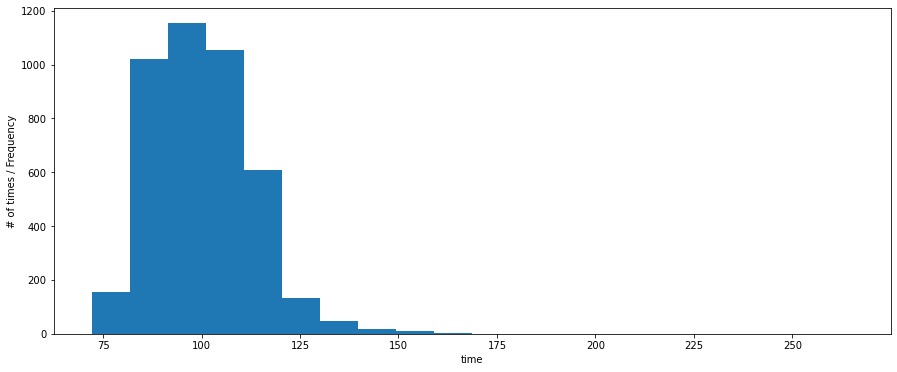

In [75]:
plt.figure(figsize=(15,6))
plt.hist(target_data,bins=20)
plt.ylabel('# of times / Frequency')
plt.xlabel('time');

#### Time is normally distributed with a mean time of around 100.

In [10]:
train.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,k,v,at,a,d,u,j,o,0,...,0,0,1,0,0,0,0,0,0,0
1,6,k,t,av,e,d,y,l,o,0,...,1,0,0,0,0,0,0,0,0,0
2,7,az,w,n,c,d,x,j,x,0,...,0,0,0,0,0,0,1,0,0,0
3,9,az,t,n,f,d,x,l,e,0,...,0,0,0,0,0,0,0,0,0,0
4,13,az,v,n,f,d,h,d,n,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#Check for missing values
train.isnull().sum().sort_values(ascending=False)

ID      0
X255    0
X264    0
X263    0
X262    0
       ..
X128    0
X127    0
X126    0
X125    0
X385    0
Length: 377, dtype: int64

### There are no missing values in the train dataset.

In [12]:
#Check the dtypes
train.dtypes.sort_values(ascending=False)

X1      object
X2      object
X3      object
X4      object
X5      object
         ...  
X132     int64
X131     int64
X130     int64
X129     int64
X385     int64
Length: 377, dtype: object

In [13]:
cols = [c for c in train.columns]
print('Feature Types:')
train[cols].dtypes.value_counts()

Feature Types:


int64     369
object      8
dtype: int64

### There are 369 numeric and 8 categorical columns in train dataset.

In [14]:
# drop the ID column since its not useful.
train = train.drop('ID', axis=1)

In [15]:
# get the numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
train_numeric = train.select_dtypes(include=numerics)
train_numeric.shape



(4209, 368)

In [16]:
train_numeric.head()

,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:

train_numeric_df = pd.DataFrame(train_numeric)
train_numeric_df.describe()


,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
count,4209.000000,4209.0,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,0.013305,0.0,0.075077,0.057971,0.428130,0.000475,0.002613,0.007603,0.007840,0.099549,...,0.318841,0.057258,0.314802,0.020670,0.009503,0.008078,0.007603,0.001663,0.000475,0.001426
std,0.114590,0.0,0.263547,0.233716,0.494867,0.021796,0.051061,0.086872,0.088208,0.299433,...,0.466082,0.232363,0.464492,0.142294,0.097033,0.089524,0.086872,0.040752,0.021796,0.037734
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# We need to drop the columns with variance zero.
train_numeric_df.var().sort_values()

X330    0.000000
X297    0.000000
X268    0.000000
X290    0.000000
X235    0.000000
          ...   
X194    0.248764
X191    0.249212
X362    0.249647
X337    0.249787
X127    0.250036
Length: 368, dtype: float64

In [19]:
#storing the variance and name of variables
variance = train_numeric_df.var()
columns = train_numeric_df.columns

In [20]:
#saving the names of variables having variance more than 0
variable = [ ]
for i in range(0,len(variance)):
    if variance[i]>0:
        variable.append(columns[i])

In [21]:
# creating a new dataframe using the above variables
train_numeric_df_new = train_numeric_df[variable]

# first five rows of the new data
train_numeric_df_new.head()

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
train_numeric_df_new.shape

(4209, 356)

#### The original shape of numeric columns was 368. After dropping columns with variance zero, the shape of numeric columns is now 356. 12 columns were dropped.

In [23]:
train_numeric_df_new.describe()

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
count,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,0.013305,0.075077,0.057971,0.428130,0.000475,0.002613,0.007603,0.007840,0.099549,0.142789,...,0.318841,0.057258,0.314802,0.020670,0.009503,0.008078,0.007603,0.001663,0.000475,0.001426
std,0.114590,0.263547,0.233716,0.494867,0.021796,0.051061,0.086872,0.088208,0.299433,0.349899,...,0.466082,0.232363,0.464492,0.142294,0.097033,0.089524,0.086872,0.040752,0.021796,0.037734
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# get the categorical columns
train_category = train.select_dtypes(include='object')
train_category.shape

(4209, 8)

In [25]:
train_category.head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n


In [26]:
# Convert the categorical columns (string) to numeric, so they are in machine readable format.
from sklearn.preprocessing import LabelEncoder
train_category = train_category.apply(LabelEncoder().fit_transform)
train_category

,X0,X1,X2,X3,X4,X5,X6,X8
0,32,23,17,0,3,24,9,14
1,32,21,19,4,3,28,11,14
2,20,24,34,2,3,27,9,23
3,20,21,34,5,3,27,11,4
4,20,23,34,5,3,12,3,13
...,...,...,...,...,...,...,...,...
4204,8,20,16,2,3,0,3,16
4205,31,16,40,3,3,0,7,7
4206,8,23,38,0,3,0,6,4
4207,9,19,25,5,3,0,11,20


In [27]:
# Now combine both numeric and categoric columns.
train_df = pd.concat([train_numeric_df_new,train_category],axis=1)

In [28]:
train_df.shape

(4209, 364)

In [29]:
train_df.head()

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X384,X385,X0,X1,X2,X3,X4,X5,X6,X8
0,0,0,1,0,0,0,0,1,0,0,...,0,0,32,23,17,0,3,24,9,14
1,0,0,0,0,0,0,0,1,0,0,...,0,0,32,21,19,4,3,28,11,14
2,0,0,0,0,0,0,1,0,0,0,...,0,0,20,24,34,2,3,27,9,23
3,0,0,0,0,0,0,0,0,0,0,...,0,0,20,21,34,5,3,27,11,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,20,23,34,5,3,12,3,13


In [30]:
# Before applying PCA, the data needs to be centered and scaled. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(train_df)
x_scaled

array([[-0.11612161, -0.28490583,  4.03112887, ...,  1.29211729,
         0.75178725,  0.33944483],
       [-0.11612161, -0.28490583, -0.24806947, ...,  1.77697445,
         1.43751106,  0.33944483],
       [-0.11612161, -0.28490583, -0.24806947, ...,  1.65576016,
         0.75178725,  1.61838949],
       ...,
       [-0.11612161,  3.50993166,  4.03112887, ..., -1.61702573,
        -0.27679847, -1.08160479],
       [-0.11612161, -0.28490583, -0.24806947, ..., -1.61702573,
         1.43751106,  1.1920746 ],
       [-0.11612161, -0.28490583, -0.24806947, ..., -1.61702573,
        -0.27679847,  1.47628453]])

In [31]:
# Scaled data has a standard deviation close to 1.
x_scaled_df = pd.DataFrame(x_scaled)
x_scaled_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,354,355,356,357,358,359,360,361,362,363
count,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,...,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03
mean,1.410068e-16,-1.611235e-15,-8.216152e-16,-5.138309e-16,-3.189023e-16,-1.847137e-15,8.829557e-16,-1.016247e-15,-1.732201e-16,1.566604e-15,...,3.698633e-16,-2.143655e-16,5.011698e-18,-1.237151e-15,-5.151498e-16,-2.304590e-16,5.653970e-16,1.452865e-15,-7.443691e-17,7.280151e-18
std,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,...,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00
min,-1.161216e-01,-2.849058e-01,-2.480695e-01,-8.652455e-01,-2.180363e-02,-5.118882e-02,-8.752714e-02,-8.889488e-02,-3.324968e-01,-4.081351e-01,...,-2.180363e-02,-3.778296e-02,-2.166513e+00,-1.302882e+00,-1.587952e+00,-1.678270e+00,-4.057130e+01,-1.617026e+00,-2.333970e+00,-1.650025e+00
25%,-1.161216e-01,-2.849058e-01,-2.480695e-01,-8.652455e-01,-2.180363e-02,-5.118882e-02,-8.752714e-02,-8.889488e-02,-3.324968e-01,-4.081351e-01,...,-2.180363e-02,-3.778296e-02,-7.833574e-01,-9.511815e-01,-8.539142e-01,-5.286503e-01,2.893816e-02,-1.010954e+00,-2.767985e-01,-9.394998e-01
50%,-1.161216e-01,-2.849058e-01,-2.480695e-01,-8.652455e-01,-2.180363e-02,-5.118882e-02,-8.752714e-02,-8.889488e-02,-3.324968e-01,-4.081351e-01,...,-2.180363e-02,-3.778296e-02,3.814051e-01,2.211532e-01,-1.198763e-01,-5.286503e-01,2.893816e-02,2.011887e-01,6.606344e-02,-8.687006e-02
75%,-1.161216e-01,-2.849058e-01,-2.480695e-01,1.155741e+00,-2.180363e-02,-5.118882e-02,-8.752714e-02,-8.889488e-02,-3.324968e-01,-4.081351e-01,...,-2.180363e-02,-3.778296e-02,9.637863e-01,1.041787e+00,7.059164e-01,1.195779e+00,2.893816e-02,9.284744e-01,7.517872e-01,9.078647e-01
max,8.611662e+00,3.509932e+00,4.031129e+00,1.155741e+00,4.586393e+01,1.953552e+01,1.142503e+01,1.124924e+01,3.007548e+00,2.450169e+00,...,4.586393e+01,2.646696e+01,1.182179e+00,1.745188e+00,2.357502e+00,1.770589e+00,2.893816e-02,1.776974e+00,1.437511e+00,1.760494e+00


In [32]:
# Perform PCA - Principal Component Analysis. PCA is a method of dimensionality reduction.
# Its useful in a dataset that has many columns(features).PCA reduces the no.of features, without losing much of information. 
# Features which arent very significant are dropped.

from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(x_scaled_df)
x_pca = pca.transform(x_scaled_df)

In [33]:
#To understand how much of the variance is explained by each of these principal components, we use explained variance ratio.
# PCA1's explained variance ratio will be more than PCA2's and so on.
pca.explained_variance_ratio_

array([0.06892669, 0.05688412, 0.04537457, 0.03426771, 0.03264309,
       0.03162661, 0.02862524, 0.02123751, 0.01970413, 0.01783195,
       0.01640066, 0.01564286, 0.01462742, 0.01448335, 0.01348286,
       0.01295162, 0.01243832, 0.01173103, 0.01121051, 0.01077278,
       0.00992513, 0.00969449, 0.00942523, 0.00909868, 0.00874224,
       0.00843069, 0.00790205, 0.00763218, 0.00733542, 0.00714906,
       0.00692957, 0.00676677, 0.00652534, 0.00641494, 0.00622692,
       0.00599196, 0.00588086, 0.00574694, 0.00563703, 0.0055341 ,
       0.00550641, 0.00540083, 0.00533911, 0.00524612, 0.00510194,
       0.00503232, 0.00495885, 0.00472692, 0.00464475, 0.00456521,
       0.00439624, 0.00432948, 0.00430322, 0.00423762, 0.00420212,
       0.00415473, 0.004067  , 0.00403463, 0.00391874, 0.00388747,
       0.00381759, 0.0037556 , 0.0037244 , 0.00365911, 0.00359567,
       0.0035523 , 0.00349701, 0.00346182, 0.00340472, 0.00334158,
       0.00330985, 0.00325522, 0.00324085, 0.00321045, 0.00316

Text(0, 0.5, 'cumulative explained variance')

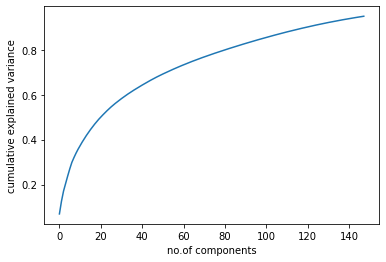

In [34]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('no.of components')
plt.ylabel('cumulative explained variance')

In [35]:

conda install -c anaconda py-xgboost

Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... done

# All requested packages already installed.



In [36]:
# After applying PCA, the no.of features are reduced from 364 to 148, without much information loss. 
# PCA improves processing time for very large datasets having many number of columns.
x_pca.shape

(4209, 148)

In [37]:
# Use XGBoost to calculate time - Dependent variable y. Since time is continuous, we use Regression. (XGBoost Regression)
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [38]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(x_pca, target_data, test_size=0.25, random_state=100)

In [39]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3156, 148)
(1053, 148)
(3156,)
(1053,)


In [40]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [41]:
prediction = xgb.predict(X_test)
print(prediction)
print(y_test)

[112.93069 112.87508  92.43454 ...  87.97561 108.06074  96.10374]
2237    109.07
3075    115.39
2849     88.03
182      91.50
1705    108.47
         ...  
1352    113.82
2620    111.19
3969     87.22
679     114.28
160      90.27
Name: y, Length: 1053, dtype: float64


In [42]:
'''
error = Actual - prediction
MSE
RMSE
MAE
'''

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

# error metrics for test data
MSE_test = mean_squared_error(y_test, prediction)
RMSE_test = sqrt(MSE_test)

MAE_test = mean_absolute_error(y_test, prediction)
MAPE_test = mean_absolute_percentage_error(y_test, prediction)

print('Mean square error for test data is :', MSE_test)
print('Root Mean square error for test data is :', RMSE_test)
print('Mean Absolute error for test data is :', MAE_test)
print('Mean Absolute percentage error for test data is :', MAPE_test)

Mean square error for test data is : 125.09451430930642
Root Mean square error for test data is : 11.184565897222226
Mean Absolute error for test data is : 6.885583578401368
Mean Absolute percentage error for test data is : 0.06476642084243112


In [43]:
# predict the time on train data
prediction_train = xgb.predict(X_train)

In [44]:
# error metric for train data

'''
error = Actual - prediction
Actual = y_train
Prediction = prediction_train
MSE
RMSE
MAE
'''

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

# error metrics for train data
MSE_train = mean_squared_error(y_train, prediction_train)
RMSE_train = sqrt(MSE_train)

MAE_train = mean_absolute_error(y_train, prediction_train)
MAPE_train = mean_absolute_percentage_error(y_train, prediction_train)

print('Mean square error for train data is :', MSE_train)
print('Root Mean square error for train data is :', RMSE_train)
print('Mean Absolute error for train data is :', MAE_train)
print('Mean Absolute percentage error for train data is :', MAPE_train)

###########################################################################
r_square = r2_score(y_train, prediction_train)
print('R square for train data is :', r_square)

Mean square error for train data is : 4.720388568998642
Root Mean square error for train data is : 2.1726455230889923
Mean Absolute error for train data is : 1.0415272187400983
Mean Absolute percentage error for train data is : 0.01017903981069537
R square for train data is : 0.9683045551881453


### R square for train data is 0.97. This is a good indicator that our model is fairly good. 

       Predicted  Actual
2237  112.930687  109.07
3075  112.875076  115.39
2849   92.434540   88.03
182    94.842033   91.50
1705  104.813004  108.47
...          ...     ...
1352   92.911240  113.82
2620  113.779289  111.19
3969   87.975609   87.22
679   108.060738  114.28
160    96.103737   90.27

[1053 rows x 2 columns]


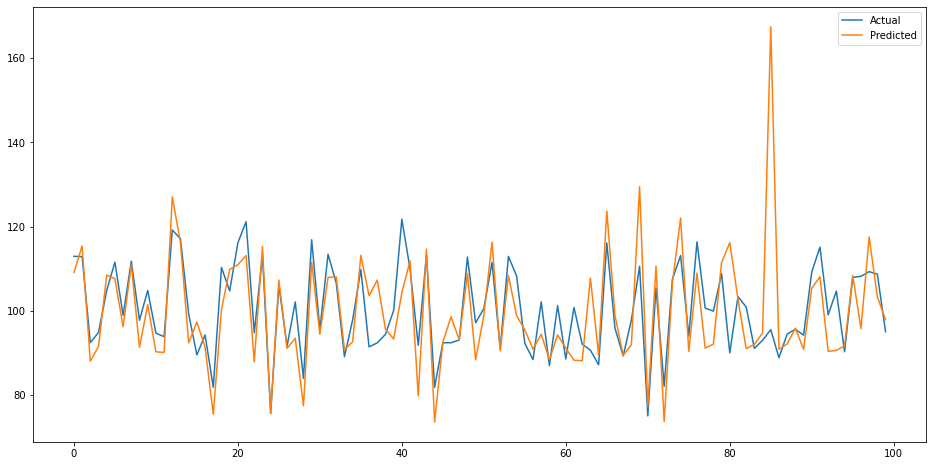

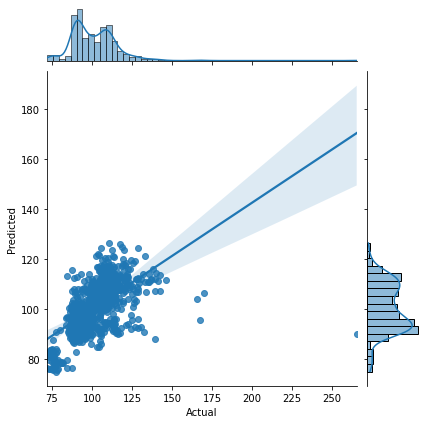

In [45]:
predicted_vs_actual = pd.DataFrame({'Predicted':prediction,'Actual':y_test})
print(predicted_vs_actual)

fig= plt.figure(figsize=(16,8))
predicted_vs_actual = predicted_vs_actual.reset_index()
predicted_vs_actual = predicted_vs_actual.drop(['index'],axis=1)
plt.plot(predicted_vs_actual[:100])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=predicted_vs_actual,kind='reg',);

In [46]:
# Now the model is ready, run the test data against the model and predict the y values.
test = pd.read_csv('test.csv')
#Check for missing values
test.isnull().sum().sort_values(ascending=False)

ID      0
X255    0
X264    0
X263    0
X262    0
       ..
X128    0
X127    0
X126    0
X125    0
X385    0
Length: 377, dtype: int64

### There are no missing values in test dataset.

In [47]:
#Check the dtypes
test.dtypes.sort_values(ascending=False)

X1      object
X2      object
X3      object
X4      object
X5      object
         ...  
X132     int64
X131     int64
X130     int64
X129     int64
X385     int64
Length: 377, dtype: object

In [48]:
cols = [c for c in test.columns]
print('Feature Types:')
test[cols].dtypes.value_counts()

Feature Types:


int64     369
object      8
dtype: int64

### There are 369 numeric and 8 categorical columns.

In [49]:
# Store ID in a separate variable.
test_ID = test['ID']
# drop the ID column from test dataset.
test = test.drop('ID', axis=1)

In [50]:
# get the numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
test_numeric = test.select_dtypes(include=numerics)
test_numeric.shape

(4209, 368)

In [51]:
test_numeric.head()

,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [52]:
test_numeric_df_new = test_numeric
# first five rows of the new data
test_numeric_df_new.head()

,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [53]:
test_numeric_df_new.shape

(4209, 368)

In [54]:
train_numeric_df_new.shape

(4209, 356)

In [55]:
# Feature difference between test and train dataset.
feature_difference = set(test_numeric_df_new) - set(train_numeric_df_new)
feature_difference

{'X107',
 'X11',
 'X233',
 'X235',
 'X268',
 'X289',
 'X290',
 'X293',
 'X297',
 'X330',
 'X347',
 'X93'}

In [56]:
# Drop the features in test data that is not present in train data. 
# This is because the model is not trained for those features. No use in keeping these features in test data. 
# Feature mismatch will occur if there are different no.of features in train and test data.

In [57]:
test_numeric_df_new= test_numeric_df_new.drop(feature_difference, axis=1)
test_numeric_df_new.shape

(4209, 356)

### The train dataset has 356 columns(after dropping zero variance). But test dataset has 368 columns. 12 columns in test dataset that is not in train dataset has been dropped. Now both train and test has equal no.of columns.

In [58]:
test_numeric_df_new.describe()

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
count,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,0.019007,0.074364,0.061060,0.427893,0.000713,0.002613,0.008791,0.010216,0.111665,0.139463,...,0.325968,0.049656,0.311951,0.019244,0.011879,0.008078,0.008791,0.000475,0.000713,0.001663
std,0.136565,0.262394,0.239468,0.494832,0.026691,0.051061,0.093357,0.100570,0.314992,0.346470,...,0.468791,0.217258,0.463345,0.137399,0.108356,0.089524,0.093357,0.021796,0.026691,0.040752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
# get the categorical columns
test_category = test.select_dtypes(include='object')
test_category.shape

(4209, 8)

In [60]:
test_category.head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,az,v,n,f,d,t,a,w
1,t,b,ai,a,d,b,g,y
2,az,v,as,f,d,a,j,j
3,az,l,n,f,d,z,l,n
4,w,s,as,c,d,y,i,m


In [61]:
# Convert the categorical columns (string) to numeric, so they are in machine readable format.
from sklearn.preprocessing import LabelEncoder
test_category = test_category.apply(LabelEncoder().fit_transform)
test_category

,X0,X1,X2,X3,X4,X5,X6,X8
0,21,23,34,5,3,26,0,22
1,42,3,8,0,3,9,6,24
2,21,23,17,5,3,0,9,9
3,21,13,34,5,3,31,11,13
4,45,20,17,2,3,30,8,12
...,...,...,...,...,...,...,...,...
4204,6,9,17,5,3,1,9,4
4205,42,1,8,3,3,1,9,24
4206,47,23,17,5,3,1,3,22
4207,7,23,17,0,3,1,2,16


In [62]:
# Now combine both numeric and categoric columns.
test_df = pd.concat([test_numeric_df_new,test_category],axis=1)

In [63]:
test_df.shape

(4209, 364)

In [64]:
test_df.head()

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X384,X385,X0,X1,X2,X3,X4,X5,X6,X8
0,0,0,0,0,0,0,0,0,0,0,...,0,0,21,23,34,5,3,26,0,22
1,0,0,0,0,0,0,0,0,1,0,...,0,0,42,3,8,0,3,9,6,24
2,0,0,0,1,0,0,0,0,0,0,...,0,0,21,23,17,5,3,0,9,9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,21,13,34,5,3,31,11,13
4,0,0,0,1,0,0,0,0,0,0,...,0,0,45,20,17,2,3,30,8,12


In [65]:
# Before applying PCA, the data needs to be centered and scaled. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(test_df)
x_scaled

array([[-0.13919465, -0.28344102, -0.25501052, ...,  1.26665157,
        -2.38888808,  1.48839606],
       [-0.13919465, -0.28344102, -0.25501052, ..., -0.69501069,
        -0.2966019 ,  1.77347725],
       [-0.13919465, -0.28344102, -0.25501052, ..., -1.73353777,
         0.74954118, -0.36463164],
       ...,
       [-0.13919465, -0.28344102, -0.25501052, ..., -1.61814587,
        -1.34274499,  1.48839606],
       [-0.13919465, -0.28344102,  3.92140688, ..., -1.61814587,
        -1.69145935,  0.63315251],
       [-0.13919465, -0.28344102, -0.25501052, ..., -1.61814587,
        -0.2966019 ,  0.7756931 ]])

In [66]:
# Scaled data has a standard deviation close to 1.
x_scaled_df = pd.DataFrame(x_scaled)
x_scaled_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,354,355,356,357,358,359,360,361,362,363
count,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,...,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03
mean,5.026074e-16,1.357379e-15,-4.848422e-16,4.184504e-16,-4.912635e-16,-1.503598e-15,-4.977605e-16,1.902863e-16,1.074086e-15,5.556391e-16,...,-5.448623e-16,-1.309174e-15,-4.911464e-17,3.031444e-15,-8.469770e-17,-1.903390e-16,-7.715509e-16,-9.561581e-15,-2.663454e-16,-1.047445e-16
std,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,...,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00
min,-1.391947e-01,-2.834410e-01,-2.550105e-01,-8.648258e-01,-2.670705e-02,-5.118882e-02,-9.417350e-02,-1.015955e-01,-3.545449e-01,-4.025732e-01,...,-2.670705e-02,-4.081511e-02,-2.005032e+00,-1.296343e+00,-1.738757e+00,-1.651020e+00,-3.815900e+01,-1.733538e+00,-2.388888e+00,-1.647497e+00
25%,-1.391947e-01,-2.834410e-01,-2.550105e-01,-8.648258e-01,-2.670705e-02,-5.118882e-02,-9.417350e-02,-1.015955e-01,-3.545449e-01,-4.025732e-01,...,-2.670705e-02,-4.081511e-02,-6.909172e-01,-9.451993e-01,-7.608673e-01,-5.253793e-01,3.629870e-02,-1.041186e+00,-2.966019e-01,-9.347940e-01
50%,-1.391947e-01,-2.834410e-01,-2.550105e-01,-8.648258e-01,-2.670705e-02,-5.118882e-02,-9.417350e-02,-1.015955e-01,-3.545449e-01,-4.025732e-01,...,-2.670705e-02,-4.081511e-02,3.603747e-01,2.252805e-01,-7.634462e-02,-5.253793e-01,3.629870e-02,2.281245e-01,5.211246e-02,-7.955045e-02
75%,-1.391947e-01,-2.834410e-01,-2.550105e-01,1.156302e+00,-2.670705e-02,-5.118882e-02,-9.417350e-02,-1.015955e-01,-3.545449e-01,-4.025732e-01,...,-2.670705e-02,-4.081511e-02,9.517264e-01,1.044616e+00,5.103891e-01,1.163082e+00,3.629870e-02,9.204759e-01,7.495412e-01,9.182337e-01
max,7.184184e+00,3.528071e+00,3.921407e+00,1.156302e+00,3.744329e+01,1.953552e+01,1.061870e+01,9.842953e+00,2.820518e+00,2.484020e+00,...,3.744329e+01,2.450073e+01,1.148844e+00,1.746904e+00,2.563957e+00,1.725903e+00,3.629870e-02,1.843611e+00,1.446970e+00,1.773477e+00


In [67]:
# Perform PCA - For test data, we dont fit the dataset. We only transform the dataset.
# We already fit transformed the train dataset.
x_pca = pca.transform(x_scaled_df)

In [68]:
pca.explained_variance_ratio_

array([0.06892669, 0.05688412, 0.04537457, 0.03426771, 0.03264309,
       0.03162661, 0.02862524, 0.02123751, 0.01970413, 0.01783195,
       0.01640066, 0.01564286, 0.01462742, 0.01448335, 0.01348286,
       0.01295162, 0.01243832, 0.01173103, 0.01121051, 0.01077278,
       0.00992513, 0.00969449, 0.00942523, 0.00909868, 0.00874224,
       0.00843069, 0.00790205, 0.00763218, 0.00733542, 0.00714906,
       0.00692957, 0.00676677, 0.00652534, 0.00641494, 0.00622692,
       0.00599196, 0.00588086, 0.00574694, 0.00563703, 0.0055341 ,
       0.00550641, 0.00540083, 0.00533911, 0.00524612, 0.00510194,
       0.00503232, 0.00495885, 0.00472692, 0.00464475, 0.00456521,
       0.00439624, 0.00432948, 0.00430322, 0.00423762, 0.00420212,
       0.00415473, 0.004067  , 0.00403463, 0.00391874, 0.00388747,
       0.00381759, 0.0037556 , 0.0037244 , 0.00365911, 0.00359567,
       0.0035523 , 0.00349701, 0.00346182, 0.00340472, 0.00334158,
       0.00330985, 0.00325522, 0.00324085, 0.00321045, 0.00316

In [69]:
# After applying PCA, the no.of features are reduced to 148. 
# The no.of features in test dataset is same as the no.of features in train dataset. 
x_pca.shape

(4209, 148)

In [70]:
# Do the prediction on already trained model.
prediction = xgb.predict(x_pca)
print(prediction)

[ 78.85895  103.4877    87.68016  ...  99.983955 108.62163   94.369995]


In [74]:
# Final Result: Predicted time that cars spend on the test bench
pd.DataFrame({'ID':test_ID,'Predicted Time':prediction})

,ID,Predicted Time
0,1,78.858948
1,2,103.487701
2,3,87.680161
3,4,88.337311
4,5,96.728081
...,...,...
4204,8410,118.983589
4205,8411,94.126724
4206,8413,99.983955
4207,8414,108.621628
